# **Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz

# **Data Cleaning**

In [2]:
# read in csv as dataframe
df_salaries_uncleaned = pd.read_csv("data/Salary_Data.csv")

# drop null entries
df_salaries_cleaned = df_salaries_uncleaned.dropna()

# standardize the degree names
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Bachelor's Degree", "Bachelor's")
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Master's Degree", "Master's")
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("phD", "PhD")

# normalize data types
df_salaries_cleaned["Age"] = df_salaries_cleaned["Age"].astype("int")
df_salaries_cleaned["Years of Experience"] = df_salaries_cleaned["Years of Experience"].astype("int")

# drop duplicate entries
df_salaries_cleaned = df_salaries_cleaned.drop_duplicates()

# show data summary
df_salaries_cleaned.info()
df_salaries_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1786 entries, 0 to 6631
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1786 non-null   int32  
 1   Gender               1786 non-null   object 
 2   Education Level      1786 non-null   object 
 3   Job Title            1786 non-null   object 
 4   Years of Experience  1786 non-null   int32  
 5   Salary               1786 non-null   float64
dtypes: float64(1), int32(2), object(3)
memory usage: 83.7+ KB


C:\Users\alexb\AppData\Local\Temp\ipykernel_17304\659578828.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Bachelor's Degree", "Bachelor's")
C:\Users\alexb\AppData\Local\Temp\ipykernel_17304\659578828.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Master's Degree", "Master's")
C:\Users\alexb\AppData\Local\Temp\ipykernel_17

Age  Gender Education Level          Job Title  Years of Experience  \
0   32    Male      Bachelor's  Software Engineer                    5   
1   28  Female        Master's       Data Analyst                    3   
2   45    Male             PhD     Senior Manager                   15   
3   36  Female      Bachelor's    Sales Associate                    7   
4   52    Male        Master's           Director                   20   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0

# **Data Exploration**

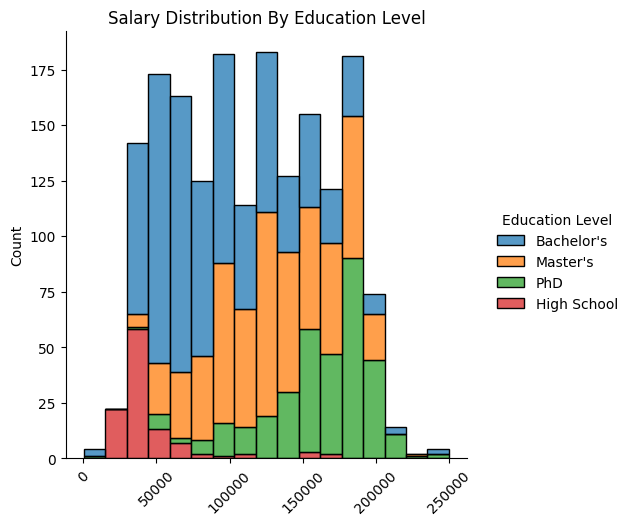

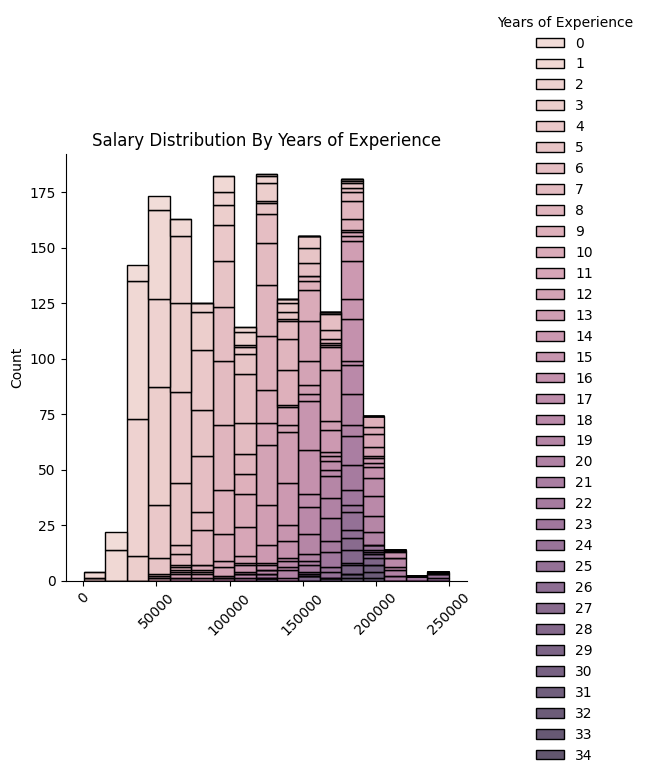

In [3]:
# Figue 1: Overall Data Distribution with Histograms
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
df_salaries_cleaned["Age"].plot(kind="hist", ax=axes[0, 0], title="Age")
df_salaries_cleaned["Years of Experience"].plot(kind="hist", ax=axes[0, 1], title="Years of Experience")
df_salaries_cleaned["Salary"].plot(kind="hist", ax=axes[0, 2], title="Salary")
df_salaries_cleaned["Gender"].value_counts().plot(kind="bar", ax=axes[1, 0], title="Gender")
df_salaries_cleaned["Education Level"].value_counts().plot(kind="bar", ax=axes[1, 1], title="Education")
df_salaries_cleaned["Job Title"].value_counts()[:20].plot(kind="bar", ax=axes[1, 2], title="Top 20 Job Titles")
fig.suptitle("Overall Data Distribution", fontsize=16)
plt.tight_layout()

# Figure 2: Data distribution - Salaries v. one factor
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
xfactor = "Gender"
g = sns.boxplot(x=xfactor, y="Salary", data=df_salaries_cleaned, ax=axes[0, 0], order=df_salaries_cleaned.groupby(xfactor)["Salary"].median().sort_values().index)
g.set(title='Gender', xlabel=None)

xfactor = "Education Level"
g = sns.boxplot(x=xfactor, y="Salary", data=df_salaries_cleaned, ax=axes[0, 1], order=df_salaries_cleaned.groupby(xfactor)["Salary"].median().sort_values().index)
g.set(title="Education Level", xlabel=None)

xfactor = "Age"
plt.xticks(rotation=90)
g = sns.boxplot(x=xfactor, y="Salary", ax=axes[1, 0], data=df_salaries_cleaned)
g.set(title="Age", xlabel=None)

xfactor = "Years of Experience"
plt.xticks(rotation=90)
g = sns.boxplot(x=xfactor, y="Salary", ax=axes[1, 1], data=df_salaries_cleaned)
g.set(title="Years of Experience", xlabel=None)

fig.suptitle("Data distribution - Salaries v. one factor", fontsize=16)
plt.tight_layout()

# Figure 3 & 4: Salary Distributions by Education Level and Years of Experience
g = sns.displot(data=df_salaries_cleaned, x="Salary", hue="Education Level", multiple="stack")
g.set(title='Salary Distribution By Education Level', xlabel=None)
plt.xticks(rotation=45)
g = sns.displot(data=df_salaries_cleaned, x="Salary", hue="Years of Experience", multiple="stack")
g.set(title="Salary Distribution By Years of Experience", xlabel=None)
p = plt.xticks(rotation=45)

C:\Users\alexb\AppData\Local\Temp\ipykernel_17304\1788837745.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_salaries_cleaned_edulvl["Education Level"] = df_salaries_cleaned["Education Level"].replace("PhD", 4)


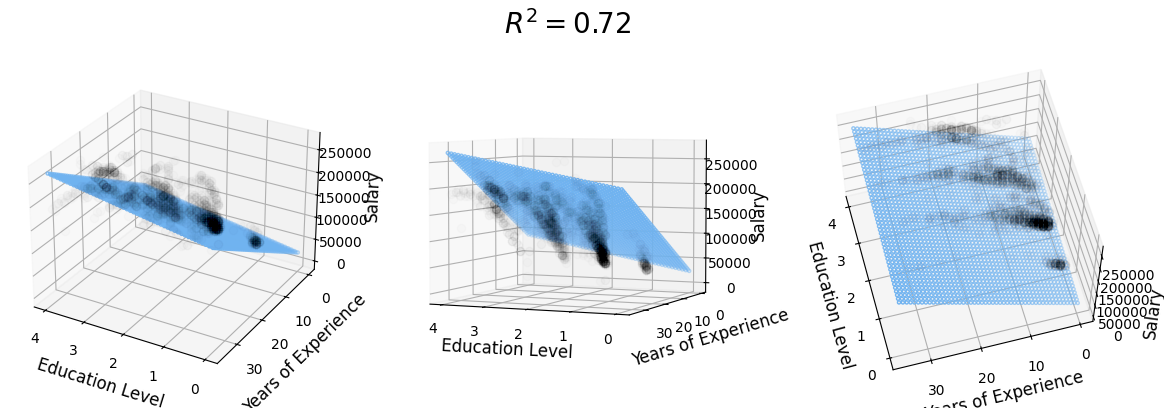

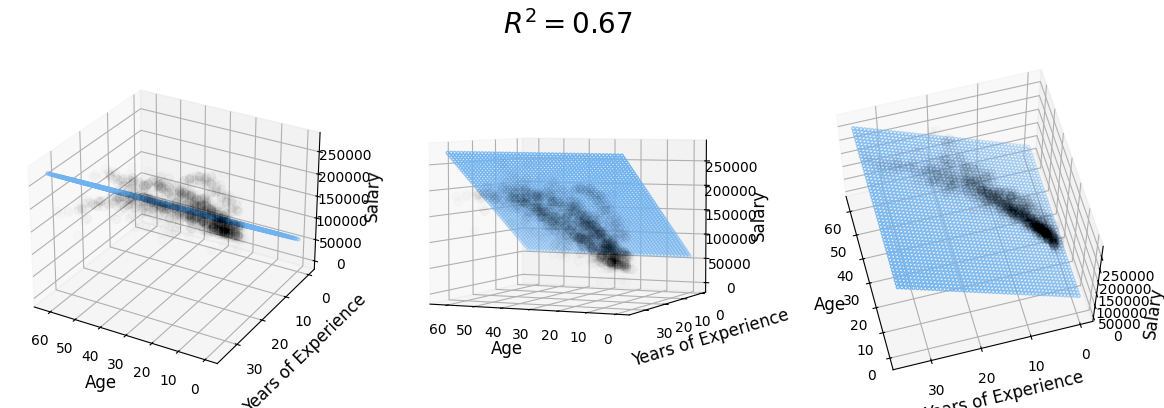

In [4]:
# test multiple different feature combinations
df_salaries_cleaned_edulvl = df_salaries_cleaned
df_salaries_cleaned_edulvl["Education Level"] = df_salaries_cleaned["Education Level"].replace("High School", 1)
df_salaries_cleaned_edulvl["Education Level"] = df_salaries_cleaned["Education Level"].replace("Bachelor's", 2)
df_salaries_cleaned_edulvl["Education Level"] = df_salaries_cleaned["Education Level"].replace("Master's", 3)
df_salaries_cleaned_edulvl["Education Level"] = df_salaries_cleaned["Education Level"].replace("PhD", 4)

# Multivariate Salary Model with Education Level and Years of Experience
X = df_salaries_cleaned_edulvl[["Education Level", "Years of Experience"]].values.reshape(-1,2)
Y = df_salaries_cleaned_edulvl["Salary"]

x = X[:, 0]
y = X[:, 1]
z = Y
x_pred = np.linspace(0, 4)
y_pred = np.linspace(0, 35)
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

ols = LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

r2 = model.score(X, Y)
plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color="k", zorder=15, linestyle="none", marker="o", alpha=0.01)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=5, edgecolor="#70b3f0")
    ax.set_xlabel("Education Level", fontsize=12)
    ax.set_ylabel("Years of Experience", fontsize=12)
    ax.set_zlabel("Salary", fontsize=12)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle("$R^2 = %.2f$" % r2, fontsize=20)

fig.tight_layout()

# Multivariate Salary Model with Age and Years of Experience
X = df_salaries_cleaned[["Age", "Years of Experience"]].values.reshape(-1,2)
Y = df_salaries_cleaned["Salary"]

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(0,62)
y_pred = np.linspace(0, 35)
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

ols = LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

r2 = model.score(X, Y)
plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color="k", zorder=15, linestyle="none", marker="o", alpha=0.01)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=5, edgecolor='#70b3f0')
    ax.set_xlabel("Age", fontsize=12)
    ax.set_ylabel("Years of Experience", fontsize=12)
    ax.set_zlabel("Salary", fontsize=12)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle("$R^2 = %.2f$" % r2, fontsize=20)

fig.tight_layout()

# **Data Preprocessing**

In [5]:
# separate categorical and numerical columns
categorical_columns = ["Gender", "Education Level", "Job Title"]
numerical_columns = ["Age", "Years of Experience"]

# separate the data into features and target values
X_data = df_salaries_cleaned[["Age", "Gender", "Education Level", "Job Title", "Years of Experience"]]
y_data = df_salaries_cleaned["Salary"]

# split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# transform table to standardize columns
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="drop"
)

# **Linear Regression**

### Hyperparameter Tuning

In [6]:
# create tuning pipeline
pipeline = make_pipeline(
    ct,
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

# hyperparameters to tune
param_grid = {
    "selectkbest__k": [1, 2, 3, 4, 5],
}

# create an exhaustive search using cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")

# perform exhaustive search to tune hyperparameters
grid_search.fit(X_data, y_data)

print("Best Features:", grid_search.best_estimator_.feature_names_in_)

Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [7]:
# create model pipeline
pipeline = make_pipeline(
    ct,
    LinearRegression()
)

# train model on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('linearregression', LinearRegression())])

### Model Evaluations

In [8]:
# predict salaries on testing data
y_pred = pipeline.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 503620136.9941846
Root Mean Squared Error (RMSE): 22441.482504375344
R2 Score: 0.8231842008148191


### Model Visualizations

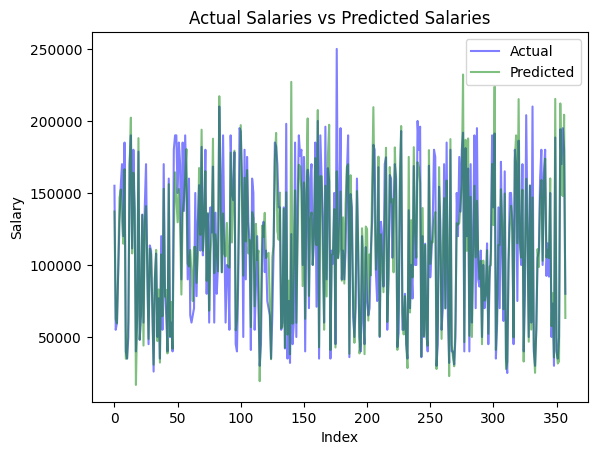

Text(0.5, 1.0, 'Absolute Error')

In [9]:
# Actual Salaries vs Predicted Salaries Graph

# table consisting of actual salaries
df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

# table consisting of predicted salaries
df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred))]})
df_predicted["y"] = y_pred

# create shared plot
ax = plt.gca()

# plot actual and predicted salaries
df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax, alpha=0.5)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax, alpha=0.5)

# set labels
ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries")

plt.show()

# Absolute Error Graph

# take the difference between each actual and predicted
df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred

# apply absolute value
df_diff = df_diff.apply(abs)

# set labels
plt.plot(df_diff["x"], df_diff["y"], color="purple", alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Salary")
plt.title("Absolute Error")

# **K-Nearest Neighbors**

### Hyperparameter Tuning

In [10]:
# create tuning pipeline
pipeline = make_pipeline(
    ct,
    SelectKBest(score_func=f_regression),
    KNeighborsRegressor(metric="euclidean")
)

# hyperparameters to tune
param_grid = {
    "selectkbest__k": [1, 2, 3, 4, 5],
    "kneighborsregressor__n_neighbors": [n for n in range(1, 10)]
}

# create an exhaustive search using cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")

# perform exhaustive search to tune hyperparameters
grid_search.fit(X_data, y_data)

print("Best N-Neighbors:", grid_search.best_params_["kneighborsregressor__n_neighbors"])
print("Best Features:", grid_search.best_estimator_.feature_names_in_)

Best N-Neighbors: 9
Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [11]:
# create model pipeline
pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=9, metric="euclidean")
)

# train model on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=9))])

### Model Evaluations

In [12]:
# predict salaries on testing data
y_pred = pipeline.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 419640080.43175393
Root Mean Squared Error (RMSE): 20485.11851153793
R2 Score: 0.8526687264045383


### Model Visualizations

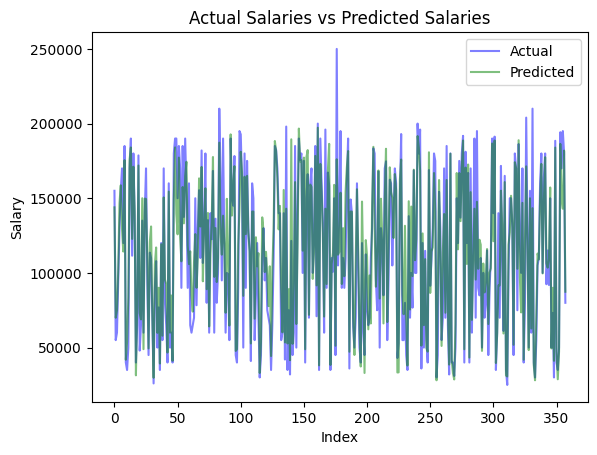

Text(0.5, 1.0, 'Absolute Error')

In [13]:
# Actual Salaries vs Predicted Salaries Graph

# table consisting of actual salaries
df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

# table consisting of predicted salaries
df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred))]})
df_predicted["y"] = y_pred

# create shared plot
ax = plt.gca()

# plot actual and predicted salaries
df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax, alpha=0.5)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax, alpha=0.5)

# set labels
ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries")

plt.show()

# Absolute Error Graph

# take the difference between each actual and predicted
df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred

# apply absolute value
df_diff = df_diff.apply(abs)

# set labels
plt.plot(df_diff["x"], df_diff["y"], color="purple", alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Salary")
plt.title("Absolute Error")

# **Random Forest**

### Hyperparameter Tuning

In [14]:
pipeline = make_pipeline(
    ct,
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# Define the hyperparameters grid for the Random Forest
param_grid = {
    'randomforestregressor__n_estimators': [100, 200],  # Number of trees in the forest
    'randomforestregressor__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'randomforestregressor__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'randomforestregressor__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1)

# Assuming X_data and y_data are your features and target variable
grid_search.fit(X_data, y_data)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Features:", grid_search.best_estimator_.feature_names_in_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200}
Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [15]:
# create model pipeline
pipeline = make_pipeline(
    ct,
    RandomForestRegressor(max_depth=30, min_samples_leaf=1, min_samples_split=5,n_estimators=200, random_state=42)
)

# train model on training data
pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=30, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

### Model Evaluation

In [16]:
y_pred = pipeline.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 268966655.6025348
Root Mean Squared Error (RMSE): 16400.202913456123
R2 Score: 0.9055686008737244


### Model Visualizations

In [17]:
# Function for extracting the features used from a pipeline's column transformer
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer."""
    output_features = []

    # Loop through each transformer within the ColumnTransformer
    for name, estimator, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer
            continue
        # Handle one-hot encoded features
        if hasattr(estimator, 'categories_'):
            for i, category in enumerate(estimator.categories_):
                output_features.extend([f"{columns[i]}_{cat}" for cat in category])
        # Handle other transformers (e.g., scaling numerical features)
        else:
            output_features.extend(columns)

    return output_features

In [18]:
random_forest_model = pipeline.named_steps['randomforestregressor']
tree = random_forest_model.estimators_[0]

# Extract feature names
transformed_feature_names = get_feature_names(pipeline.named_steps['columntransformer'])

# Export the tree to a DOT format
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=transformed_feature_names, 
                           filled=True, rounded=True, 
                           special_characters=True, max_depth=3)  # Limiting tree depth for readability

# Use graphviz to render the DOT data
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

'decision_tree.pdf'

In [19]:
# Actual Salaries vs Predicted Salaries Graph

# table consisting of actual salaries
df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

# table consisting of predicted salaries
df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred))]})
df_predicted["y"] = y_pred

# create shared plot
ax = plt.gca()

# plot actual and predicted salaries
df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax, alpha=0.65)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax, alpha=0.65)

# set labels
ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries for Random Forest Model")

plt.show()

# Absolute Error Graph

# take the difference between each actual and predicted
df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred

# apply absolute value
df_diff = df_diff.apply(abs)

# set labels
plt.plot(df_diff["x"], df_diff["y"], color="purple", alpha=0.65)
plt.xlabel("Index")
plt.ylabel("Salary")
plt.title("Absolute Error for Random Forest Model")

Text(0.5, 1.0, 'Absolute Error for Random Forest Model')